In [1]:
using LinearAlgebra
using SparseArrays
using Plots

function xy(
    x0::Float64, 
    y0::Float64, 
    L1::Float64, 
    L2::Float64, 
    noelms1::Int64, 
    noelms2::Int64
)::Tuple{Vector{Float64}, Vector{Float64}}
    VX = repeat(collect(LinRange(x0, x0+L1, noelms1+1)), inner=noelms2+1)
    VY = repeat(collect(LinRange(y0+L2, y0, noelms2+1)), noelms1+1)
    return VX, VY
end

function conelmtab(noelms1::Int64, noelms2::Int64)::Matrix{Int64}
    k = [i for i in 1:(noelms1*(noelms2+1)) if i % (noelms2+1) != 0]

    return [
        k (2 + noelms2 .+ k) (1 + noelms2 .+ k);
        k (1 .+ k) (2 + noelms2 .+ k)
    ]
end

function constructBnodes(
    VX::Vector{Float64},
    VY::Vector{Float64},
    tol::Float64,
    fd::Function,
)::Vector{Int64}
    return findall(abs.(fd.(VX, VY)) .<= tol)
end

function square_regular_mesh(
    x0::Float64, 
    y0::Float64, 
    L1::Float64, 
    L2::Float64, 
    noelms1::Int64, 
    noelms2::Int64,
)::Tuple{Vector{Float64}, Vector{Float64}, Matrix{Int64}, Vector{Int64}}
    VX, VY = xy(x0, y0, L1, L2, noelms1, noelms2)
    EToV = conelmtab(noelms1, noelms2)

    fd_gamma(x, y) = min(x - x0, y - y0, x0 + L1 - x, y0 + L2 - y)
    tol = 0.0001
    bnodes = constructBnodes(VX, VY, tol, fd_gamma)

    return VX, VY, EToV, bnodes
end

function basfun(
    VX::Vector{Float64}, 
    VY::Vector{Float64}, 
    EToV::Matrix{Int64}
)::Tuple{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}
    xj = VX[EToV[:, [2,3,1]]]
    yj = VY[EToV[:, [2,3,1]]]

    xk = VX[EToV[:, [3,1,2]]]
    yk = VY[EToV[:, [3,1,2]]]

    at = xj .* yk - xk .* yj
    bt = yj - yk
    ct = xk - xj

    return at, bt, ct
end

function constructBeds(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    tol::Float64,
    fd::Function,
)::Matrix{Int64}
    xc = (VX[EToV] + VX[EToV[:, [2, 3, 1]]]) ./ 2
    yc = (VY[EToV] + VY[EToV[:, [2, 3, 1]]]) ./ 2
    return getindex.(findall(abs.(fd.(xc, yc)) .<= tol), [1 2])
end

function assembly(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    lam1::Float64,
    lam2::Float64,
    qt::Vector{Float64},
    c::Vector{Float64},
    abs_delta::Vector{Float64},
    bt::Matrix{Float64}, 
    ct::Matrix{Float64}
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Vector{Float64}}
    N = size(EToV)[1]
    M = length(VX)

    A = spzeros(M, M)
    C = spzeros(M, M)
    b = zeros(M)

    for n in 1:N
        abs_delta_n = abs_delta[n]
        btn = bt[n, :]
        ctn = ct[n, :]

        EToV_n = EToV[n,:]
        qtn = abs_delta_n * sum(qt[EToV_n]) / 9
        cn = sum(c[EToV_n]) / 3

        for r in 1:3
            i = EToV_n[r]
            b[i] += qtn

            for s in r:3
                j = EToV_n[s]

                ij_min = min(i, j)
                ij_max = max(i, j)
                
                A[ij_min, ij_max] += (lam1*btn[r]*btn[s] + lam2*ctn[r]*ctn[s]) / (4 * abs_delta_n)
                C[ij_min, ij_max] += cn * abs_delta_n * (1 + (r == s)) / 12
            end
        end
    end

    return A, C, b
end

function dirbc(
    bnodes::Vector{Int64}, 
    f::Vector{Float64}, 
    A::SparseMatrixCSC{Float64, Int64}, 
    C::SparseMatrixCSC{Float64, Int64}, 
    b::Vector{Float64}
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Vector{Float64}, Vector{Float64}}
    d = zeros(length(b))

    for (i, k) in enumerate(bnodes)
        b[k] = 0
        A[k, k] = 0
        C[k, k] = 1

        indices1 = findall(A[1:k-1, k] .!= 0)
        indices2 = findall(A[k, 1+k:end] .!= 0) .+ k

        temp1 = A[indices1,k] .* f[i]
        temp2 = A[k,indices2] .* f[i]

        b[indices1] -= temp1
        b[indices2] -= temp2

        d[indices1] += temp1
        d[indices2] += temp2

        A[indices1, k] .= 0
        A[k, indices2] .= 0

        indices1 = findall(C[1:k-1, k] .!= 0)
        indices2 = findall(C[k, 1+k:end] .!= 0) .+ k

        C[indices1, k] .= 0
        C[k, indices2] .= 0
    end

    return A, C, b, d
end

function mod_system_vec(
    n::Int64,
    EToV::Matrix{Int64},
    qt::Vector{Float64},
    abs_delta::Vector{Float64}
)::Vector{Float64}
    b = zeros(n)
    N = size(EToV)[1]

    for n in 1:N
        EToV_n = EToV[n,:]
        qtn = abs_delta[n] * sum(qt[EToV_n]) / 9
        for r in 1:3
            i = EToV_n[r]
            b[i] += qtn
        end
    end

    return b
end

function solve_time_depedent_dirchlet_BVP(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    lam1::Float64,
    lam2::Float64,
    qt::Function,
    c::Function,
    f::Function,
    bnodes::Vector{Int64},
    theta::Float64,
    u0::Vector{Float64},
    dt::Float64,
    N::Int64
)::Matrix{Float64}
    at, bt, ct = basfun(VX, VY, EToV)
    abs_delta = abs.(vec(sum(at, dims=2)) ./ 2)

    R, S, b = assembly(VX, VY, EToV, lam1, lam2, qt.(VX, VY, 0), c.(VX, VY), abs_delta, bt, ct)
    R, S, b, d = dirbc(bnodes, f.(VX[bnodes], VY[bnodes], 0), R, S, b)

    d1 = dt * theta
    d2 = dt * (1.0 - theta)
    S -= d2 * R
    R = S + dt * R

    R = Symmetric(R)
    S = Symmetric(S)

    uhat = zeros(length(u0), N+1)
    uhat[:, 1] = u0

    for n in 1:N
        e = S * uhat[:, n]
        e += d2 * b

        b = mod_system_vec(length(b), EToV, qt.(VX, VY, n*dt), abs_delta)
        b[bnodes] .= 0
        b -= d

        e += d1 * b
        uhat[:, n+1] = R \ e
    end

    return uhat
end

function solve_square_time_depedent_dirchlet_BVP(
    x0::Float64, 
    y0::Float64, 
    L1::Float64, 
    L2::Float64, 
    noelms1::Int64, 
    noelms2::Int64, 
    lam1::Float64,
    lam2::Float64,
    qt::Function,
    c::Function,
    f::Function,
    theta::Float64,
    g::Function,
    dt::Float64,
    N::Int64
)::Tuple{Vector{Float64}, Vector{Float64}, Matrix{Float64}}
    VX, VY, EToV, bnodes = square_regular_mesh(x0,y0,L1,L2,noelms1,noelms2)
    u0 = g.(VX, VY)
    uhat = solve_time_depedent_dirchlet_BVP(VX,VY,EToV,lam1,lam2,qt,c,f,bnodes,theta,u0,dt,N)
    return VX, VY, uhat
end

solve_square_time_depedent_dirchlet_BVP (generic function with 1 method)

[ Info: Saved animation to /home/jakob/Uni/Fem/code/week 3/tmp.gif


Plots.AnimatedGif("/home/jakob/Uni/Fem/code/week 3/tmp.gif")
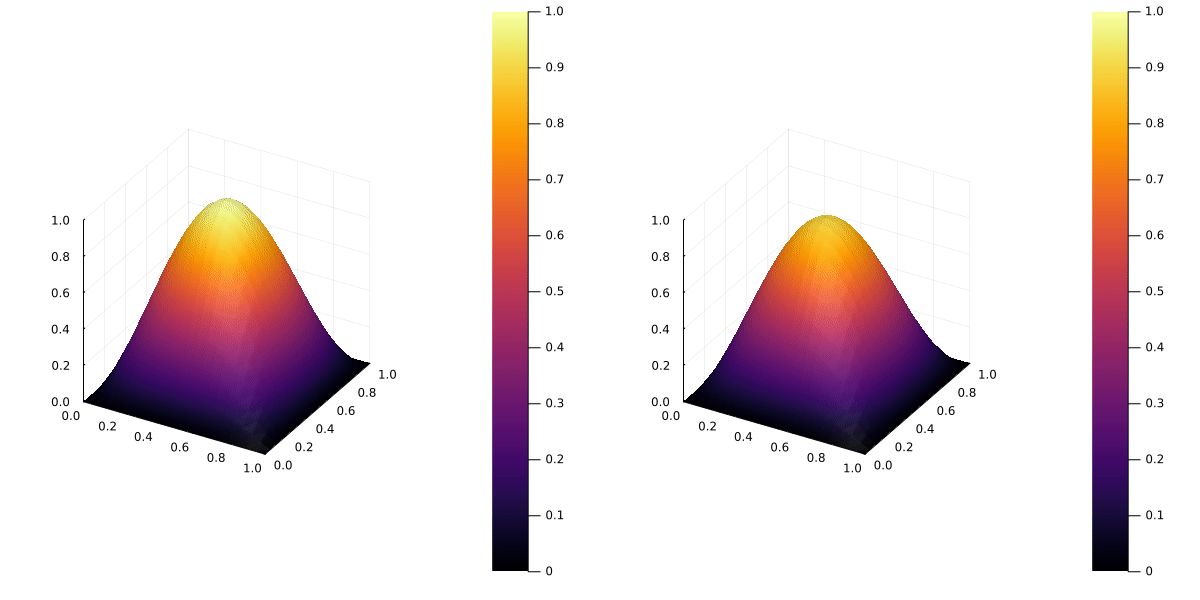

In [6]:
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
noelms1 = 20
noelms2 = 20
lam1 = lam2 = 1.0
qt(x,y,t) = 0.0
c(x,y) = 1.0
f(x, y) = 0.0
g(x, y) = sin(pi * x) * sin(pi * y)
theta = 0.5
dt = 0.005
N = 25

VX, VY, uhat = solve_square_time_depedent_dirchlet_BVP(x0,y0,L1,L2,noelms1,noelms2,lam1,lam2,qt,c,f,theta,g,dt,N)

v = 1.0
u(x, y, t) = exp(-2 * pi^2 * v * t) * sin(pi * x) * sin(pi * y)

anim = @animate for i in 1:size(uhat)[2]
    p1 = plot(VX, VY, uhat[:, i], st=:surface, zlim=(0,1), clim=(0,1))
    p2 = plot(VX, VY, u.(VX, VY, i*dt), st=:surface, zlims=(0,1), clims =(0,1))
    plot(p1, p2, layout=(1,2), size=(1200, 600))
end

gif(anim, fps=10)

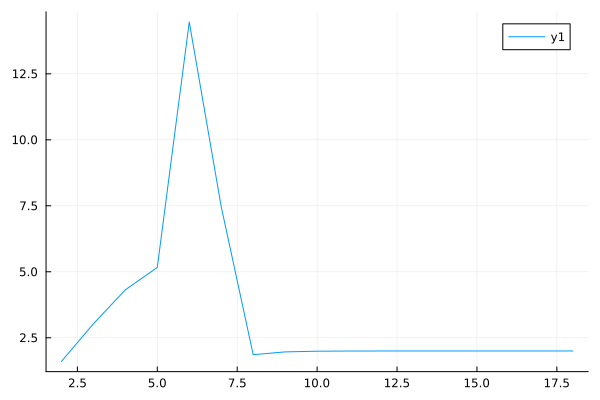

In [3]:
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
noelms1 = 4
noelms2 = 4
lam1 = lam2 = 1.0
qt(x,y,t) = 0.0
c(x,y) = 1.0
f(x, y) = 0.0
g(x, y) = sin(pi * x) * sin(pi * y)
theta = 0.5

VX, VY, EToV, bnodes = square_regular_mesh(x0,y0,L1,L2,noelms1,noelms2)
u0 = g.(VX, VY)

t = 1.0
M = 18
uhats = zeros(length(u0), M+1)
q = zeros(M-1)

for p in 0:M
    N = 2^p
    dt = t/N
    uhats[:, p+1] = solve_time_depedent_dirchlet_BVP(VX,VY,EToV,lam1,lam2,qt,c,f,bnodes,theta,u0,dt,N)[:, end]

    if p >= 2
        q[p-1] = log2(maximum(abs, uhats[:,p-1] - uhats[:,p]) / maximum(abs, uhats[:,p] - uhats[:,p+1]))
    end
end

display(plot(2:M, q))

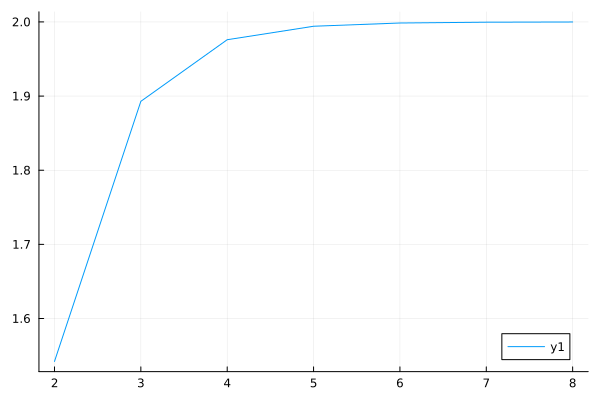

In [5]:
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
noelms1 = 4
noelms2 = 4
lam1 = lam2 = 1.0
qt(x,y,t) = 0.0
c(x,y) = 1.0
f(x, y) = 0.0
g(x, y) = sin(pi * x) * sin(pi * y)
theta = 0.5

v = 1.0
u(x, y, t) = exp(-2 * pi^2 * v * t) * sin(pi * x) * sin(pi * y)

t = 0.1
M = 8
uhats = [Float64[] for _ in 1:M]
uanals = [Float64[] for _ in 1:M]
q = zeros(M-1)

for p in 1:M
    N = 2^p
    dt = t/N
    noelms1 = noelms2 = N

    VX, VY, uhat =  solve_square_time_depedent_dirchlet_BVP(x0,y0,L1,L2,noelms1,noelms2,lam1,lam2,qt,c,f,theta,g,dt,N)

    uhats[p] = uhat[:, end]
    uanals[p] = u.(VX, VY, t)

    if p >= 2
        q[p-1] = log2(maximum(abs, uhats[p-1] - uanals[p-1]) / maximum(abs, uhats[p] - uanals[p]))
    end
end

display(plot(2:M, q))

[ Info: Saved animation to /home/jakob/Uni/Fem/code/week 3/tmp.gif


Plots.AnimatedGif("/home/jakob/Uni/Fem/code/week 3/tmp.gif")
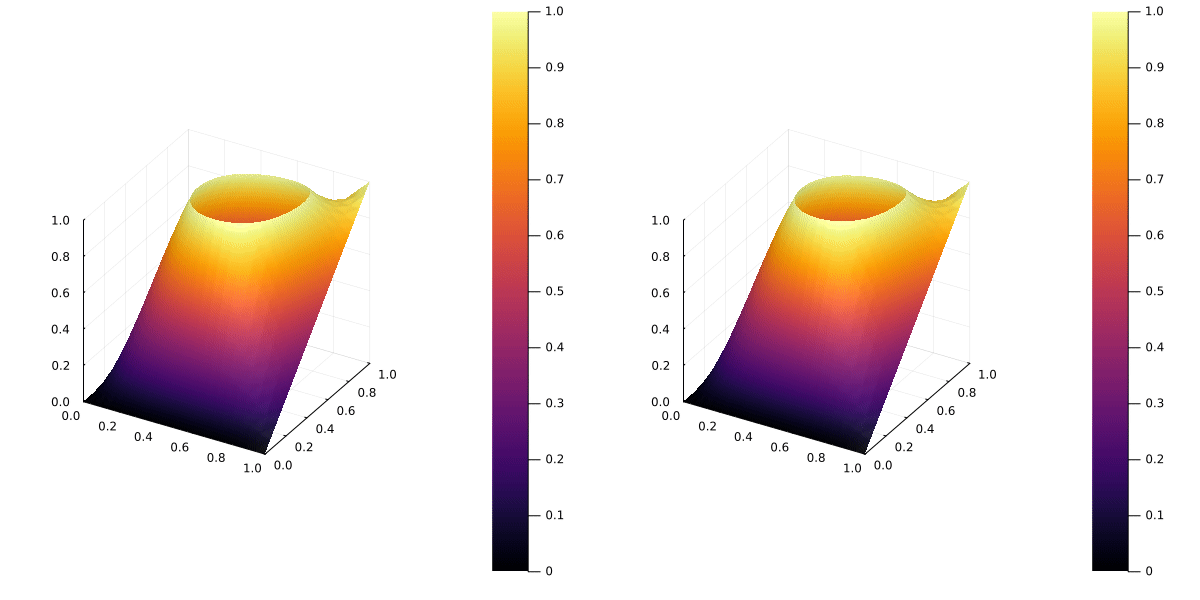

In [14]:
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
noelms1 = 20
noelms2 = 20
lam1 = lam2 = 1.0
v = 1.0
qt(x,y,t) = v * pi^2 * exp(-pi^2 * v * t) * sin(pi*x) * sin(pi*y)
c(x,y) = 1.0
f(x, y) = x * y
g(x, y) = sin(pi*x) * sin(pi*y) + x*y
theta = 0.5
dt = 0.005
N = 25

VX, VY, uhat = solve_square_time_depedent_dirchlet_BVP(x0,y0,L1,L2,noelms1,noelms2,lam1,lam2,qt,c,f,theta,g,dt,N)

u(x, y, t) = exp(-pi^2 * v * t) * sin(pi*x) * sin(pi*y) + x*y

anim = @animate for i in 1:size(uhat)[2]
    p1 = plot(VX, VY, uhat[:, i], st=:surface, zlim=(0,1), clim=(0,1))
    p2 = plot(VX, VY, u.(VX, VY, i*dt), st=:surface, zlims=(0,1), clims =(0,1))
    plot(p1, p2, layout=(1,2), size=(1200, 600))
end

gif(anim, fps=10)

In [ ]:
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
noelms1 = 20
noelms2 = 20
lam1 = lam2 = 1.0
v = 1.0
qt(x,y,t) = v * pi^2 * exp(-pi^2 * v * t) * sin(pi*x) * sin(pi*y)
c(x,y) = 1.0
f(x, y) = x * y
g(x, y) = sin(pi*x) * sin(pi*y) + x*y
theta = 0.5

VX, VY, EToV, bnodes = square_regular_mesh(x0,y0,L1,L2,noelms1,noelms2)
u0 = g.(VX, VY)

t = 1.0
M = 18
uhats = zeros(length(u0), M+1)
q = zeros(M-1)

for p in 0:M
    N = 2^p
    dt = t/N
    uhats[:, p+1] = solve_time_depedent_dirchlet_BVP(VX,VY,EToV,lam1,lam2,qt,c,f,bnodes,theta,u0,dt,N)[:, end]

    if p >= 2
        q[p-1] = log2(maximum(abs, uhats[:,p-1] - uhats[:,p]) / maximum(abs, uhats[:,p] - uhats[:,p+1]))
    end
end

display(plot(2:M, q))

[ Info: Saved animation to /home/jakob/Uni/Fem/code/week 3/tmp.gif


Plots.AnimatedGif("/home/jakob/Uni/Fem/code/week 3/tmp.gif")
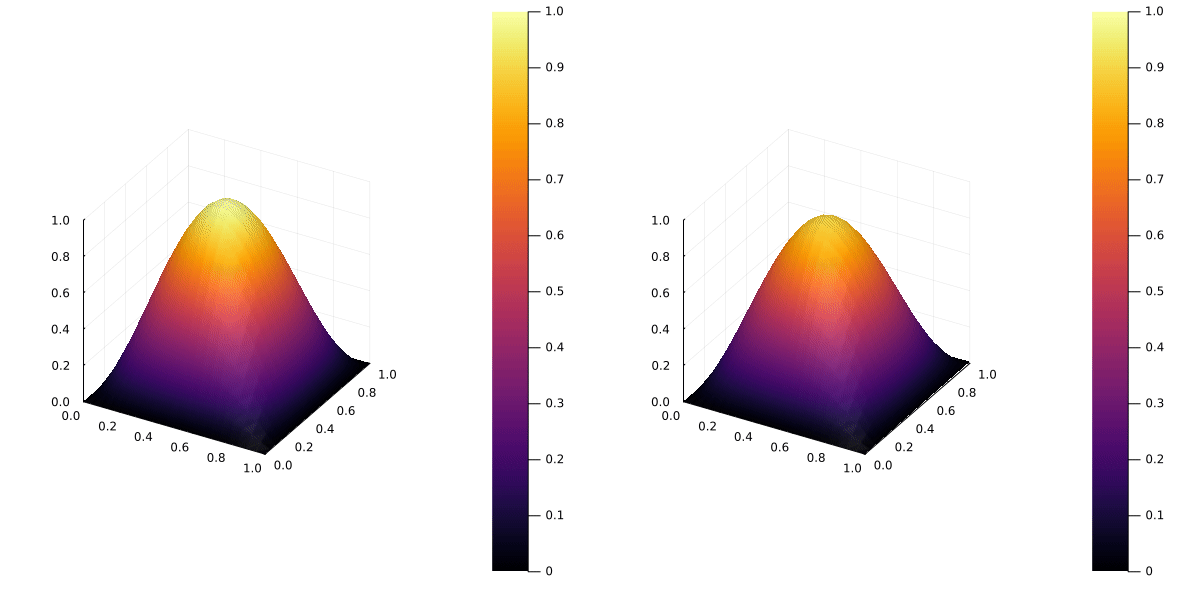

In [15]:
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
noelms1 = 20
noelms2 = 20
lam1 = lam2 = 1.0
v = 1.0
qt(x,y,t) = pi/2 * x * y * cos(pi/2 * t)
c(x,y) = 1.0
f(x, y) = x * y * sin(pi/2 * t)
g(x, y) = sin(pi*x) * sin(pi*y)
theta = 0.5
dt = 0.005
N = 25

VX, VY, uhat = solve_square_time_depedent_dirchlet_BVP(x0,y0,L1,L2,noelms1,noelms2,lam1,lam2,qt,c,f,theta,g,dt,N)

u(x, y, t) = exp(-2 * pi^2 * v * t) * sin(pi*x) * sin(pi*y) + x*y*sin(pi/2 * t)

anim = @animate for i in 1:size(uhat)[2]
    p1 = plot(VX, VY, uhat[:, i], st=:surface, zlim=(0,1), clim=(0,1))
    p2 = plot(VX, VY, u.(VX, VY, i*dt), st=:surface, zlims=(0,1), clims =(0,1))
    plot(p1, p2, layout=(1,2), size=(1200, 600))
end

gif(anim, fps=10)